# Task 1

   pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0             63.03        22.55                  39.61         40.48   
1             39.06        10.06                  25.02         29.00   
2             68.83        22.22                  50.09         46.61   
3             69.30        24.65                  44.31         44.64   
4             49.71         9.65                  28.32         40.06   

   pelvic_radius  degree_spondylolisthesis class  
0          98.67                     -0.25    DH  
1         114.41                      4.56    DH  
2         105.99                     -3.53    DH  
3         101.87                     11.21    DH  
4         108.17                      7.92    DH  
First 5 rows of the dataset:
   pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0             63.03        22.55                  39.61         40.48   
1             39.06        10.06                  25.02         29.00   
2      

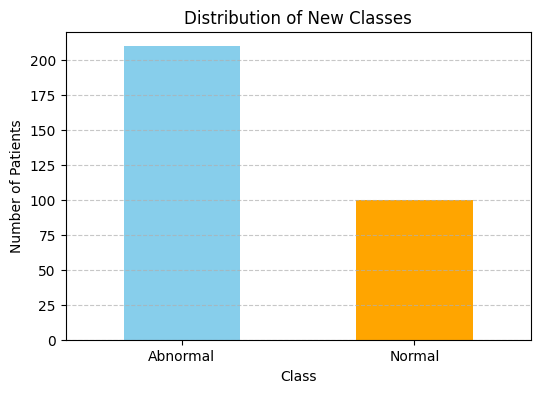

In [48]:
# Load the packages that I will use
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pickle

# Set seed for reproducibility
SEED = 42

# Import data from GitHub
url = "https://raw.githubusercontent.com/lrnv/inf-gram/main/6_final_project/column_3C.txt"
df = pd.read_csv(url, sep='\s+', header=0)
print(df.head())

# a. Display the first lines
print("First 5 rows of the dataset:")
print(df.head())

# b. Display the number of rows and columns
rows, cols = df.shape
print("\nNumber of rows:", rows)
print("Number of columns:", cols)

# c. Check the data type of each column
print("\nData types of each column:")
print(df.dtypes)

# d. Check if there is any missing value
print("\nNumber of missing values in each column:")
print(df.isnull().sum())
print("\nThere are no missing values")

# e. Count the number of rows for each class
print("\nNumber of patients in each class:")
print(df['class'].value_counts())

# Create a new column 'new_class' based on the mapping
df['new_class'] = df['class'].apply(lambda x: 'Normal' if x == 'NO' else 'Abnormal')

# Display the new class distribution as a table
new_class_counts = df['new_class'].value_counts()
print("\nNew class distribution:")
print(new_class_counts)

# Plot the distribution as a bar graph
plt.figure(figsize=(6, 4))
new_class_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Distribution of New Classes')
plt.xlabel('Class')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0) #Ensures the class names (Normal, Abnormal) are displayed horizontally
plt.grid(axis='y', linestyle='--', alpha=0.7) # Adds dashed gridlines only along the y-axis and sets transparency
plt.show()

# Task 2


Mean and Standard Deviation for Features (Original Data):
      pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
mean         60.496484    17.542903              51.930710     42.953871   
std          17.236109    10.008140              18.553766     13.422748   

      pelvic_radius  degree_spondylolisthesis  
mean     117.920548                 26.296742  
std       13.317629                 37.558883  

Mean and Standard Deviation for Each Numeric Feature by Class (Original Data):
          pelvic_incidence            pelvic_tilt             \
                      mean        std        mean        std   
new_class                                                      
Abnormal         64.692143  17.661807   19.791048  10.515653   
Normal           51.685600  12.367900   12.821800   6.778658   

          lumbar_lordosis_angle            sacral_slope             \
                           mean        std         mean        std   
new_class                  

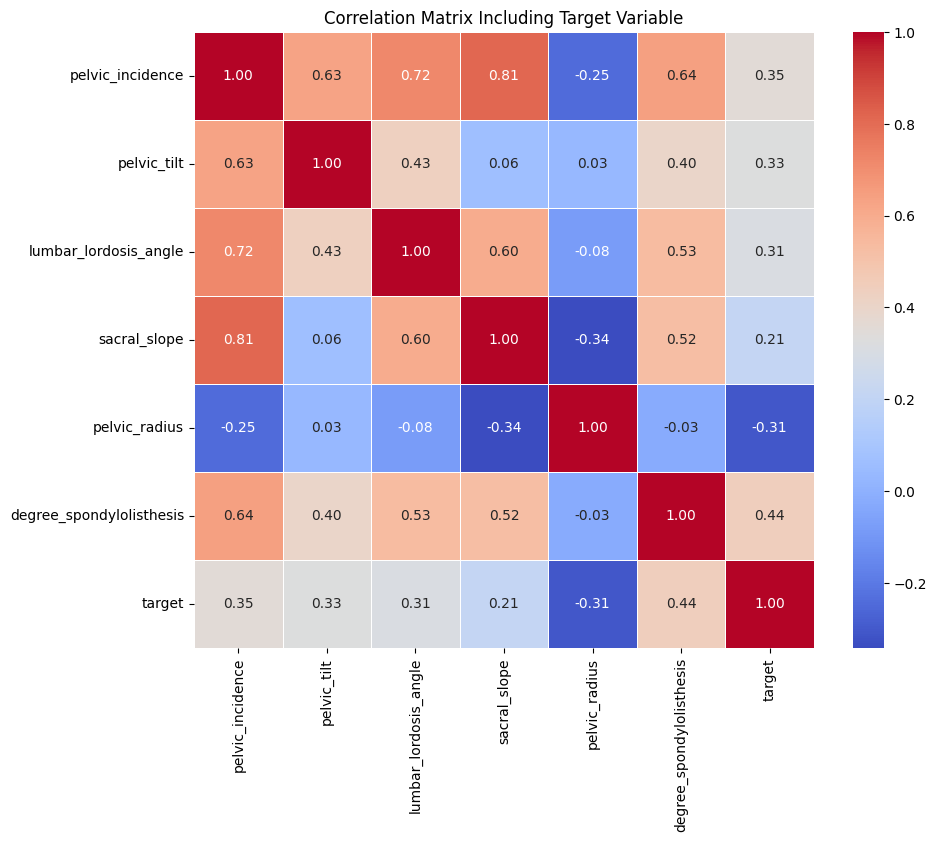

Pelvic incidence and sacral slope show a high positive correlation.
There is also a moderately strong positive correlation between sacral slope and lumbar lordosis
The pelvic radius shows relatively low correlation with other features
Degree spondylolisthesis shows variability in correlation across the other features


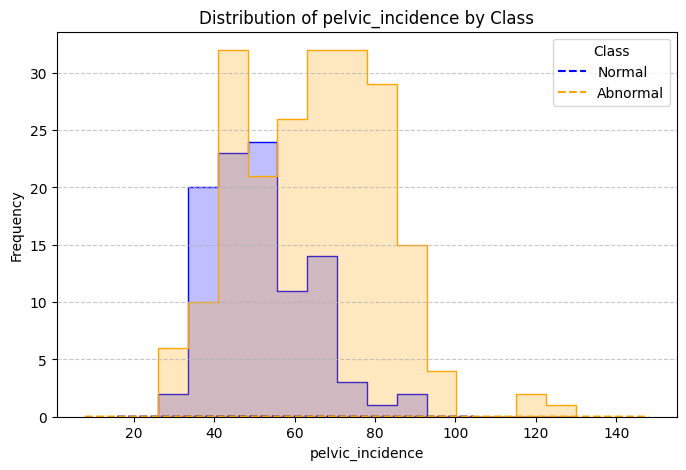

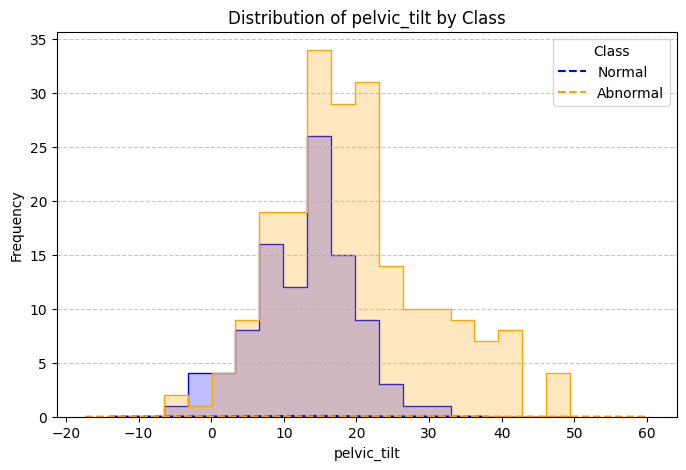

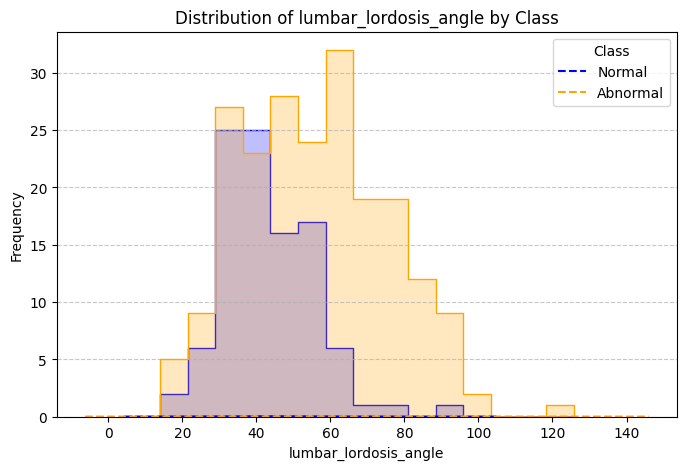

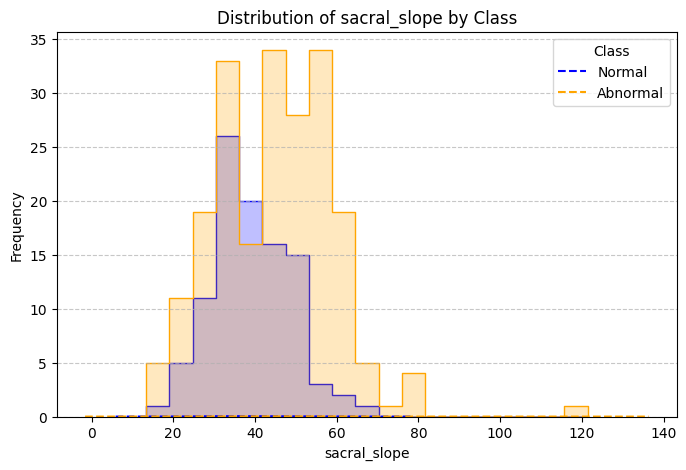

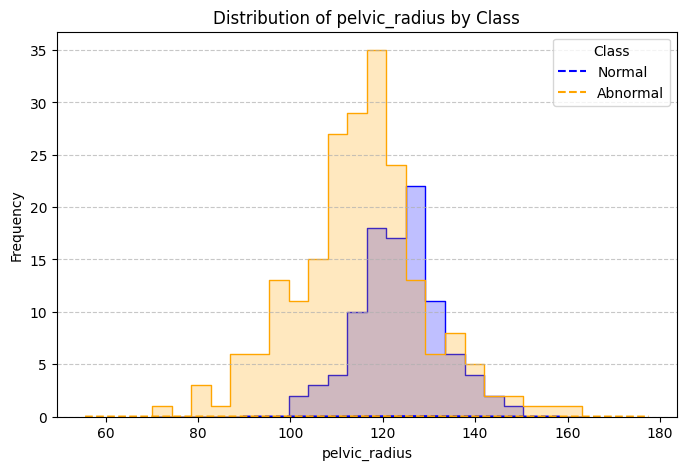

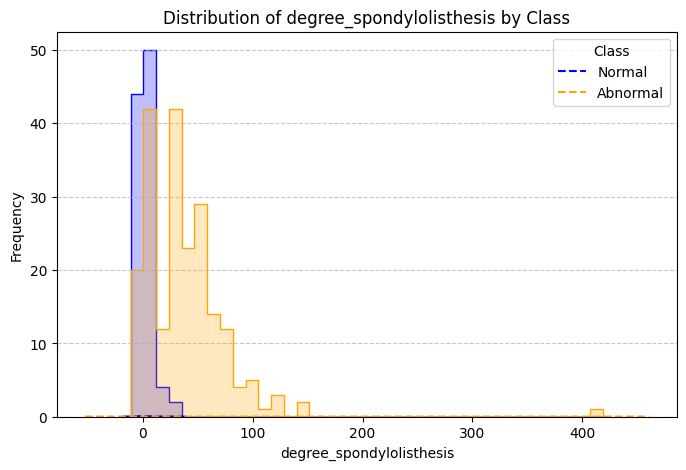

In [49]:
# Add target variable and ensure numeric features exclude it
df['target'] = (df['new_class'] == 'Abnormal').astype(int)
numeric_features = df.select_dtypes(include=[np.number]).columns.drop('target')

# 1. Mean and standard deviation for numeric features
feature_stats = df[numeric_features].describe().loc[['mean', 'std']]
print("\nMean and Standard Deviation for Features (Original Data):")
print(feature_stats)

# 2. Mean and standard deviation for each numeric feature by class
grouped_stats = df.groupby('new_class')[numeric_features].agg(['mean', 'std'])
print("\nMean and Standard Deviation for Each Numeric Feature by Class (Original Data):")
print(grouped_stats)

print("The mean values for most features are higher in the abnormal group than in the normal group, with the exception of pelvic radius")
print("The abnormal class has higher standard deviations for all features, ie. there is more variability, as also shown in the histograms")


# 3. Correlation matrix
correlation_matrix = df[numeric_features.tolist() + ['target']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Including Target Variable')
plt.show()

print("Pelvic incidence and sacral slope show a high positive correlation.")
print("There is also a moderately strong positive correlation between sacral slope and lumbar lordosis")
print("The pelvic radius shows relatively low correlation with other features")
print("Degree spondylolisthesis shows variability in correlation across the other features")

# Histograms for each feature by class
for feature in numeric_features:
    plt.figure(figsize=(8, 5))

    # Plot histogram with hue
    sns.histplot(
        data=df,
        x=feature,
        hue='new_class',
        palette={"Normal": "blue", "Abnormal": "orange"},
        kde=False,
        element="step"
    )

    # Add KDE plots manually to avoid conflicts with the hue
    sns.kdeplot(
        data=df[df['new_class'] == 'Normal'],
        x=feature,
        color="blue",
        linestyle="--",
        label="Normal"
    )
    sns.kdeplot(
        data=df[df['new_class'] == 'Abnormal'],
        x=feature,
        color="orange",
        linestyle="--",
        label="Abnormal"
    )

    # Titles and labels
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Explicit legend
    plt.legend(title='Class', loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Perform the dataset splitting and scaling at the end
X = df[numeric_features]  # Features
y = df['target']  # Target variable

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Standardize training and test sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Task 3 - Logistic Regression

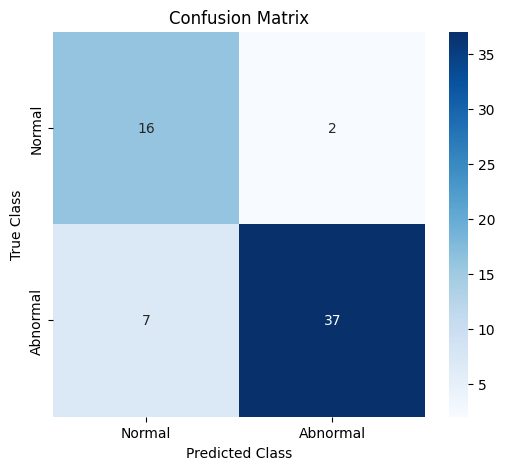


Classification Report:
              precision    recall  f1-score   support

      Normal       0.70      0.89      0.78        18
    Abnormal       0.95      0.84      0.89        44

    accuracy                           0.85        62
   macro avg       0.82      0.86      0.84        62
weighted avg       0.88      0.85      0.86        62



In [37]:
# 1. Build logistic regression model and fit to the training data
log_reg = LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced')
log_reg.fit(X_train, y_train)

# Predict on the test sample
log_reg_pred = log_reg.predict(X_test)

# 2. Compute and display the confusion matrix
conf_matrix = confusion_matrix(y_test, log_reg_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# 3. Performance indicators
classification_report_str = classification_report(y_test, log_reg_pred, target_names=['Normal', 'Abnormal'])
print("\nClassification Report - Logistic Regression:")
print(classification_report_str)

# Save the Logistic Regression model
with open('log_reg_model.pkl', 'wb') as f:
    pickle.dump(log_reg, f)



# Task 4 - Random Forest classifier

In this case I have chosen to usa Random Forest classifier because there are interactions between features as shown in the correlation matrix,

Robust to Overfitting: By averaging the results of multiple decision trees, RF reduces the risk of overfitting, which is especially useful when dealing with biomedical data where noise or irrelevant features can exist.

When you want a model that is interpretable in terms of feature importance.

Handles Non-Linearity: RF is a tree-based model that can handle complex, non-linear relationships between features and the target variable.

Feature Importance: RF provides a straightforward way to measure the importance of each feature, which can offer insights into which variables are most significant in distinguishing between Normal and Abnormal cases.



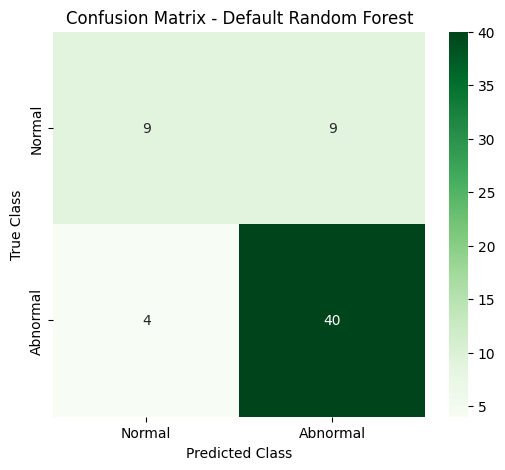


Classification Report - Default Random Forest:
              precision    recall  f1-score   support

      Normal       0.69      0.50      0.58        18
    Abnormal       0.82      0.91      0.86        44

    accuracy                           0.79        62
   macro avg       0.75      0.70      0.72        62
weighted avg       0.78      0.79      0.78        62


Best Parameters for Random Forest Recall-Score:
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


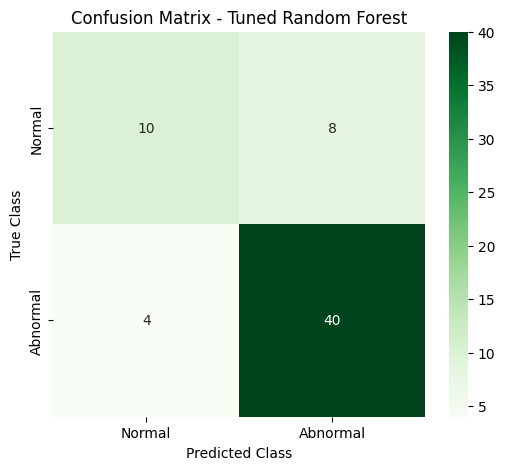


Classification Report - Tuned Random Forest:
              precision    recall  f1-score   support

      Normal       0.71      0.56      0.62        18
    Abnormal       0.83      0.91      0.87        44

    accuracy                           0.81        62
   macro avg       0.77      0.73      0.75        62
weighted avg       0.80      0.81      0.80        62



In [50]:
# Custom scorers for F1-score and Recall
f1_scorer = make_scorer(f1_score)
recall_scorer = make_scorer(recall_score)

# 1. Default Random Forest Model
rf_model = RandomForestClassifier(random_state=SEED, class_weight="balanced")
rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)

# Confusion Matrix
rf_conf_matrix = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix - Default Random Forest')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Performance
print("\nClassification Report - Default Random Forest:")
print(classification_report(y_test, rf_pred, target_names=['Normal', 'Abnormal']))

# Hyperparameter Tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring=recall_scorer) #since we're screening for severe conditions like disk hernia or spondylolisthesis, prioritizing recall ensures that fewer abnormal patients are missed.
grid_search_rf.fit(X_train, y_train)

# Best Parameters
print("\nBest Parameters for Random Forest Recall-Score:")
print(grid_search_rf.best_params_)

# Best Model
best_rf_model = grid_search_rf.best_estimator_
best_rf_pred = best_rf_model.predict(X_test)

# Confusion Matrix for Best Model
best_rf_conf_matrix = confusion_matrix(y_test, best_rf_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(best_rf_conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix - Tuned Random Forest')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Performance Indicators
print("\nClassification Report - Tuned Random Forest:")
print(classification_report(y_test, best_rf_pred, target_names=['Normal', 'Abnormal']))


# Task 5 - Support Vector Machine SVM

Why SVM?

Handles Non-Linear Decision Boundaries: By using different kernels (e.g., radial basis function, polynomial), SVM can model non-linear relationships, making it versatile for classification tasks.
Focus on Margins: SVM finds the optimal hyperplane that maximizes the margin between classes, often resulting in better generalization compared to other models.
Robust to Outliers: SVM is less sensitive to outliers compared to other algorithms like Logistic Regression, making it a good choice for potentially noisy biomedical data.
When to Use SVM?
When the dataset is well-separated or has clear class boundaries.

### Grid Search for rbf kernel ###

Metrics for the rbf kernel with default parameters


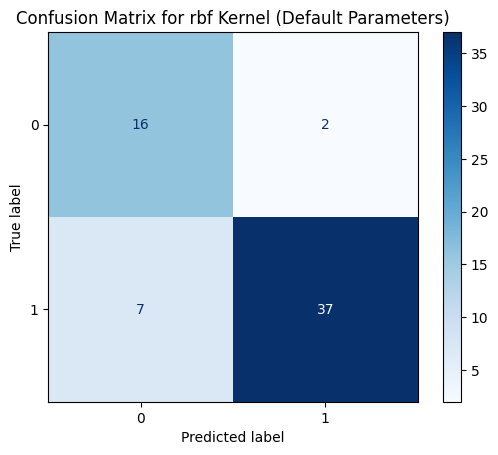

### Grid Search for rbf kernel ###

Best parameters set found on development set:
{'C': 1000, 'gamma': 0.0089, 'kernel': 'rbf'}
0.506 (+/-0.024) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.743 (+/-0.109) for {'C': 1, 'gamma': 0.0012000000000000001, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.761 (+/-0.130) for {'C': 1, 'gamma': 0.0023, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.758 (+/-0.120) for {'C': 1, 'gamma': 0.0034, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.758 (+/-0.120) for {'C': 1, 'gamma': 0.0045000000000000005, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.755 (+/-0.129) for {'C': 1, 'gamma': 0.005600000000000001, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.767 (+/-0.122) for {'C': 1, 'gamma': 0.0067, 'kernel': 'rbf'}
Best macro recall du

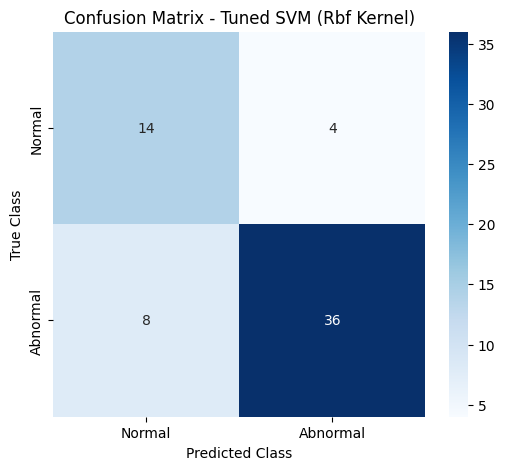

### Grid Search for linear kernel ###

Best parameters set found on development set:
{'C': 100, 'kernel': 'linear'}
0.838 (+/-0.063) for {'C': 1, 'kernel': 'linear'}
Best macro recall during training (cross-validation): 0.841
0.838 (+/-0.063) for {'C': 10, 'kernel': 'linear'}
Best macro recall during training (cross-validation): 0.841
0.841 (+/-0.065) for {'C': 100, 'kernel': 'linear'}
Best macro recall during training (cross-validation): 0.841
0.841 (+/-0.065) for {'C': 1000, 'kernel': 'linear'}
Best macro recall during training (cross-validation): 0.841

Detailed classification report:
              precision    recall  f1-score   support

           0       0.70      0.89      0.78        18
           1       0.95      0.84      0.89        44

    accuracy                           0.85        62
   macro avg       0.82      0.86      0.84        62
weighted avg       0.88      0.85      0.86        62



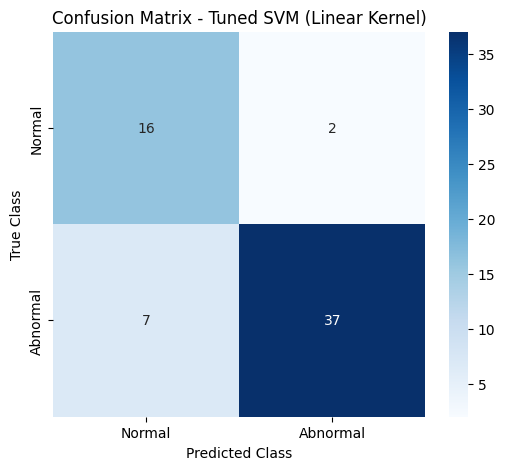

### Grid Search for poly kernel ###

Best parameters set found on development set:
{'C': 1000, 'degree': 3, 'kernel': 'poly'}
0.707 (+/-0.107) for {'C': 1, 'degree': 2, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.739 (+/-0.106) for {'C': 1, 'degree': 3, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.668 (+/-0.131) for {'C': 1, 'degree': 4, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.654 (+/-0.070) for {'C': 1, 'degree': 5, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.728 (+/-0.099) for {'C': 10, 'degree': 2, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.735 (+/-0.164) for {'C': 10, 'degree': 3, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.694 (+/-0.117) for {'C': 10, 'degree': 4, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.679 (+/-0.149) for {'C

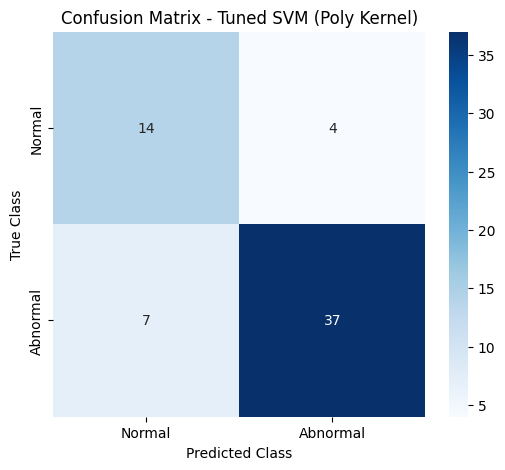

### Grid Search for linear kernel ###

Metrics for the linear kernel with default parameters


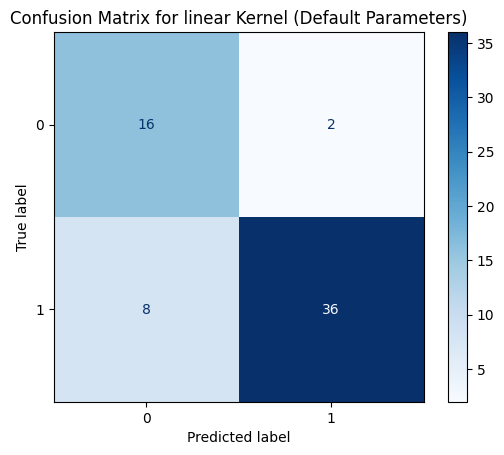

### Grid Search for rbf kernel ###

Best parameters set found on development set:
{'C': 1000, 'gamma': 0.0089, 'kernel': 'rbf'}
0.506 (+/-0.024) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.743 (+/-0.109) for {'C': 1, 'gamma': 0.0012000000000000001, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.761 (+/-0.130) for {'C': 1, 'gamma': 0.0023, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.758 (+/-0.120) for {'C': 1, 'gamma': 0.0034, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.758 (+/-0.120) for {'C': 1, 'gamma': 0.0045000000000000005, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.755 (+/-0.129) for {'C': 1, 'gamma': 0.005600000000000001, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.767 (+/-0.122) for {'C': 1, 'gamma': 0.0067, 'kernel': 'rbf'}
Best macro recall du

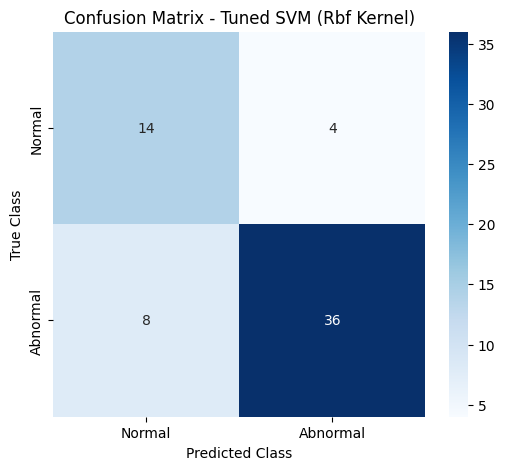

### Grid Search for linear kernel ###

Best parameters set found on development set:
{'C': 100, 'kernel': 'linear'}
0.838 (+/-0.063) for {'C': 1, 'kernel': 'linear'}
Best macro recall during training (cross-validation): 0.841
0.838 (+/-0.063) for {'C': 10, 'kernel': 'linear'}
Best macro recall during training (cross-validation): 0.841
0.841 (+/-0.065) for {'C': 100, 'kernel': 'linear'}
Best macro recall during training (cross-validation): 0.841
0.841 (+/-0.065) for {'C': 1000, 'kernel': 'linear'}
Best macro recall during training (cross-validation): 0.841

Detailed classification report:
              precision    recall  f1-score   support

           0       0.70      0.89      0.78        18
           1       0.95      0.84      0.89        44

    accuracy                           0.85        62
   macro avg       0.82      0.86      0.84        62
weighted avg       0.88      0.85      0.86        62



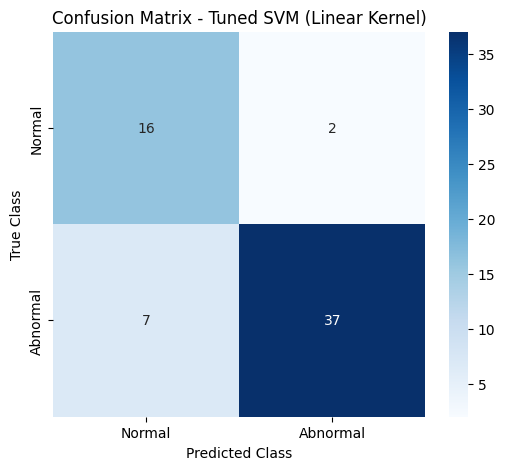

### Grid Search for poly kernel ###

Best parameters set found on development set:
{'C': 1000, 'degree': 3, 'kernel': 'poly'}
0.707 (+/-0.107) for {'C': 1, 'degree': 2, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.739 (+/-0.106) for {'C': 1, 'degree': 3, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.668 (+/-0.131) for {'C': 1, 'degree': 4, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.654 (+/-0.070) for {'C': 1, 'degree': 5, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.728 (+/-0.099) for {'C': 10, 'degree': 2, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.735 (+/-0.164) for {'C': 10, 'degree': 3, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.694 (+/-0.117) for {'C': 10, 'degree': 4, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.679 (+/-0.149) for {'C

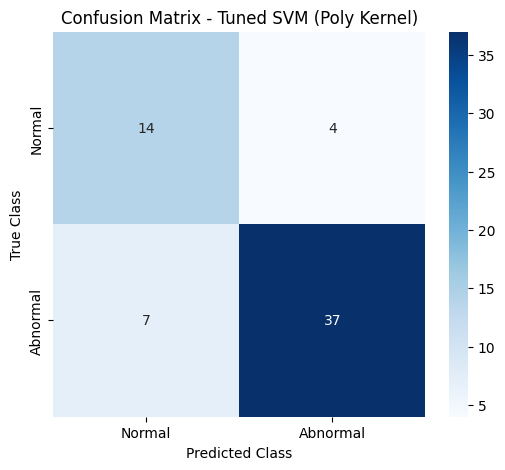

### Grid Search for poly kernel ###

Metrics for the poly kernel with default parameters


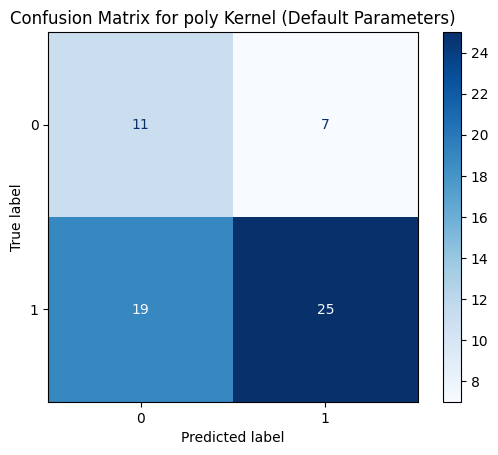

### Grid Search for rbf kernel ###

Best parameters set found on development set:
{'C': 1000, 'gamma': 0.0089, 'kernel': 'rbf'}
0.506 (+/-0.024) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.743 (+/-0.109) for {'C': 1, 'gamma': 0.0012000000000000001, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.761 (+/-0.130) for {'C': 1, 'gamma': 0.0023, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.758 (+/-0.120) for {'C': 1, 'gamma': 0.0034, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.758 (+/-0.120) for {'C': 1, 'gamma': 0.0045000000000000005, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.755 (+/-0.129) for {'C': 1, 'gamma': 0.005600000000000001, 'kernel': 'rbf'}
Best macro recall during training (cross-validation): 0.862
0.767 (+/-0.122) for {'C': 1, 'gamma': 0.0067, 'kernel': 'rbf'}
Best macro recall du

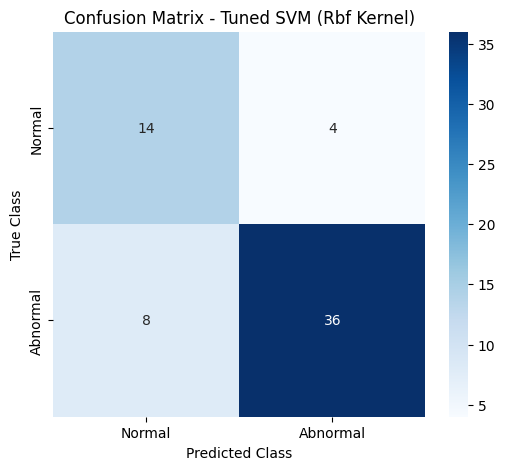

### Grid Search for linear kernel ###

Best parameters set found on development set:
{'C': 100, 'kernel': 'linear'}
0.838 (+/-0.063) for {'C': 1, 'kernel': 'linear'}
Best macro recall during training (cross-validation): 0.841
0.838 (+/-0.063) for {'C': 10, 'kernel': 'linear'}
Best macro recall during training (cross-validation): 0.841
0.841 (+/-0.065) for {'C': 100, 'kernel': 'linear'}
Best macro recall during training (cross-validation): 0.841
0.841 (+/-0.065) for {'C': 1000, 'kernel': 'linear'}
Best macro recall during training (cross-validation): 0.841

Detailed classification report:
              precision    recall  f1-score   support

           0       0.70      0.89      0.78        18
           1       0.95      0.84      0.89        44

    accuracy                           0.85        62
   macro avg       0.82      0.86      0.84        62
weighted avg       0.88      0.85      0.86        62



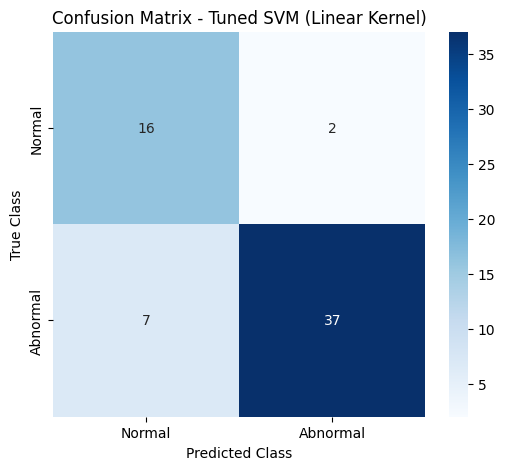

### Grid Search for poly kernel ###

Best parameters set found on development set:
{'C': 1000, 'degree': 3, 'kernel': 'poly'}
0.707 (+/-0.107) for {'C': 1, 'degree': 2, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.739 (+/-0.106) for {'C': 1, 'degree': 3, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.668 (+/-0.131) for {'C': 1, 'degree': 4, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.654 (+/-0.070) for {'C': 1, 'degree': 5, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.728 (+/-0.099) for {'C': 10, 'degree': 2, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.735 (+/-0.164) for {'C': 10, 'degree': 3, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.694 (+/-0.117) for {'C': 10, 'degree': 4, 'kernel': 'poly'}
Best macro recall during training (cross-validation): 0.785
0.679 (+/-0.149) for {'C

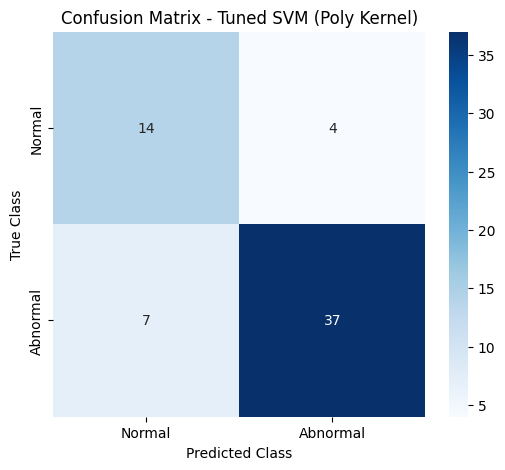


### Best SVM Model Information based on test data###
The best kernel is: rbf
The best score is: 0.8620098039215687
The best SVM model is: SVC(C=1000, class_weight='balanced', gamma=0.0089, probability=True,
    random_state=42)


In [51]:
# Create variables to hold the best model information
best_score = -np.inf
best_svm = None
best_kernel = None

# Dictionaries to store the best models and hyperparameters for each kernel
best_models = {}
best_hyperparams = {}

# Define gamma range and parameters for each kernel
gamma_vector = np.linspace(1e-4, 1e-2, num=10)

kernel_parameters = {
    'rbf': {'kernel': ['rbf'], 'gamma': gamma_vector, 'C': [1, 10, 100, 1000]},
    'linear': {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
    'poly': {'kernel': ['poly'], 'C': [1, 10, 100, 1000], 'degree': [2, 3, 4, 5]}
}

# Metrics to evaluate
scores = ['recall']

# Loop over kernels
for kernel, params in kernel_parameters.items():
    print(f"### Grid Search for {kernel} kernel ###\n")

    # Initialize the default SVM for the current kernel
    default_svm = SVC(**{k: v[0] for k, v in params.items() if isinstance(v, list)}, class_weight='balanced', probability=True, random_state=SEED)
    default_svm.fit(X_train, y_train)  # Use scaled data

    # Predict and evaluate metrics for the default SVM
    y_pred = default_svm.predict(X_test_scaled)
    print(f"Metrics for the {kernel} kernel with default parameters")
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=default_svm.classes_).plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {kernel} Kernel (Default Parameters)")
    plt.show()

    # Loop over kernels
    for kernel, params in kernel_parameters.items():
        print(f"### Grid Search for {kernel} kernel ###\n")

        # Grid search with scoring metric
        clf = GridSearchCV(
            SVC(class_weight='balanced', probability=True, random_state=SEED),
            [params],
            scoring=f'{scores[0]}_macro',  # Using recall as scoring
            cv=5
        )

        # Train the model
        clf.fit(X_train, y_train)  # Use scaled data

        # Save the best model and hyperparameters for this kernel
        best_models[kernel] = clf.best_estimator_  # Save the best model
        best_hyperparams[kernel] = clf.best_params_  # Save the best hyperparameters

        # Print best parameters
        print("Best parameters set found on development set:")
        print(clf.best_params_)

        # Print grid scores
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, param in zip(means, stds, clf.cv_results_['params']):
            print(f"{mean:.3f} (+/-{std * 2:.03f}) for {param}")
            print(f"Best macro recall during training (cross-validation): {clf.best_score_:.3f}")

        # Evaluate the best model on the test set
        print("\nDetailed classification report:")
        svm_pred = clf.best_estimator_.predict(X_test)
        print(classification_report(y_test, svm_pred))

        # Display confusion matrix for the best model
        cm = confusion_matrix(y_test, svm_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
        plt.title(f'Confusion Matrix - Tuned SVM ({kernel.capitalize()} Kernel)')
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.show()

        # Track the best model overall based on the current score
        if clf.best_score_ > best_score:
            best_score = clf.best_score_
            best_svm = clf.best_estimator_
            best_kernel = kernel

# Output the best model information
print("\n### Best SVM Model Information based on test data###")
print(f"The best kernel is: {best_kernel}")
print(f"The best score is: {best_score}")
print(f"The best SVM model is: {best_svm}")

# Save the best models and their parameters for further use
with open("best_svm_models.pkl", "wb") as f:
    pickle.dump(best_models, f)

with open("best_svm_hyperparams.pkl", "wb") as f:
    pickle.dump(best_hyperparams, f)

# Task 6 - Select best model

In [52]:
# Generate predictions for all models with properly scaled data
log_reg_pred = log_reg.predict(X_test)  # Logistic Regression Predictions
best_rf_pred = best_rf_model.predict(X_test)  # Random Forest Predictions
best_rbf_pred = best_models['rbf'].predict(X_test)  # RBF SVM Predictions
best_linear_pred = best_models['linear'].predict(X_test)  # Linear SVM Predictions
best_poly_pred = best_models['poly'].predict(X_test)  # Polynomial SVM Predictions

# Create a table to compare all models
performance_data = {
    'Model': [
        'Logistic Regression',
        'Tuned Random Forest',
        'Tuned SVM (RBF)',
        'Tuned SVM (Linear)',
        'Tuned SVM (Polynomial)'
    ],
    'Accuracy': [
        log_reg.score(X_test, y_test),
        best_rf_model.score(X_test, y_test),
        best_models['rbf'].score(X_test, y_test),
        best_models['linear'].score(X_test, y_test),
        best_models['poly'].score(X_test, y_test)
    ],
    'Precision (Abnormal)': [
        classification_report(y_test, log_reg_pred, output_dict=True)['1']['precision'],
        classification_report(y_test, best_rf_pred, output_dict=True)['1']['precision'],
        classification_report(y_test, best_rbf_pred, output_dict=True)['1']['precision'],
        classification_report(y_test, best_linear_pred, output_dict=True)['1']['precision'],
        classification_report(y_test, best_poly_pred, output_dict=True)['1']['precision']
    ],
    'Recall (Abnormal)': [
        classification_report(y_test, log_reg_pred, output_dict=True)['1']['recall'],
        classification_report(y_test, best_rf_pred, output_dict=True)['1']['recall'],
        classification_report(y_test, best_rbf_pred, output_dict=True)['1']['recall'],
        classification_report(y_test, best_linear_pred, output_dict=True)['1']['recall'],
        classification_report(y_test, best_poly_pred, output_dict=True)['1']['recall']
    ],
    'F1-Score (Abnormal)': [
        classification_report(y_test, log_reg_pred, output_dict=True)['1']['f1-score'],
        classification_report(y_test, best_rf_pred, output_dict=True)['1']['f1-score'],
        classification_report(y_test, best_rbf_pred, output_dict=True)['1']['f1-score'],
        classification_report(y_test, best_linear_pred, output_dict=True)['1']['f1-score'],
        classification_report(y_test, best_poly_pred, output_dict=True)['1']['f1-score']
    ]
}

# Create a DataFrame for the performance comparison
performance_df = pd.DataFrame(performance_data)

# Display the table
print("\nModel Performance Comparison:")
print(performance_df)



Model Performance Comparison:
                    Model  Accuracy  Precision (Abnormal)  Recall (Abnormal)  \
0     Logistic Regression  0.854839              0.948718           0.840909   
1     Tuned Random Forest  0.806452              0.833333           0.909091   
2         Tuned SVM (RBF)  0.806452              0.900000           0.818182   
3      Tuned SVM (Linear)  0.854839              0.948718           0.840909   
4  Tuned SVM (Polynomial)  0.822581              0.902439           0.840909   

   F1-Score (Abnormal)  
0             0.891566  
1             0.869565  
2             0.857143  
3             0.891566  
4             0.870588  
